In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from utils.matrix import project_points, project_covariance, to_homogeneous
from utils.colmap_data import COLMAP_Data
from utils.plot_utils import create_ellipsoids_as_one_mesh
from src.gaussian import GaussianSplatting
from matplotlib.collections import EllipseCollection

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [40]:
import numpy as np
from utils.matrix import quaternion_to_rotation_vectorized
from utils.colmap_data import COLMAP_Data
from scipy.spatial import KDTree


class GaussianSplatting:
    def __init__(self, colmap_data: COLMAP_Data, images_path='data/images'):
        """
        M ← SfM Points ⊲ Positions
        """
        self.points = colmap_data.points
        self.colors = colmap_data.colors

        # self.images, self.height, self.width = self.get_images(images_path)
        self.sigmas = None
        self.alphas = None

    # def get_images(self, images_path):
    #     images_data = sorted(glob(images_path + '/*.png'))
    #     with ThreadPoolExecutor() as executor: # faster loading
    #         images = list(executor.map(cv2.imread, images_data))
    #     height, width, _ = images[0].shape
    #     return images, height, width
    
    def init_attributes(self):
        """
        𝑆,𝐶, 𝐴 ← InitAttributes() ⊲ Covariances, Colors, Opacities

        https://medium.com/@yianyao1994/gaussian-splatting-part-2-representation-and-initialization-c0a036adf16e
        
        Center: Set to the point cloud locations from SfM.
        Scaling factor: Initialized as isotropic, using the mean distance to the 3-nearest neighbors.
        Rotation: No initial rotation is applied.
        Opacity: Set to 0.1.
        Spherical Harmonics (SH): Inherited from the color information in the point cloud.

        """
        # 3D covariance matrix Σ
        pass

    def init_gaussian_covariance(self):
        """
        Explanation
        Sec 4: 
            Directly optimizing covariance matrix Σ can lead to non positive non semi-definite covariance matrices.
            Instead, we factorize Σ = 𝑅𝑆𝑆^𝑇𝑅^𝑇 [7dof], allowing anisotropic covariance and valid covariance matrices.
            For independent optimization, we store S: 3D vector for scaling and quaternion q (normalize to get valid unit quaternion)

            Convert these splats to pixel space
                W viewing transformation or extrinsics
                J Jacobian projective transformation or intrinsics
                Σ' = JW Σ W^TJ^T

        Initialization
        Sec 5.1
            "We estimate the initial covariance matrix as an isotropic Gaussian 
            with axes equal to the mean of the distance to the closest three points."

        Gradient Computation
        Appendix A
            dΣ' / ds = dΣ'/dΣ * dΣ / ds
            dΣ' / dq = dΣ'/dΣ * dΣ / dq

        Simplify Σ' = JW Σ W^TJ^T using U=JW and Σ' being (symmetric) upper left 2x2
        Σ' = U Σ U^T
        """
        points = self.points

        # non gradient implementation for now
        # Have to revist complexity of KDTree
        kdtree = KDTree(points)
        distances, _ = kdtree.query(points, k=4)  # k=4 includes the point itself
        
        nearest_distances = distances[:, 1:4]
        mean_distances = nearest_distances.mean(axis=1)

        unit_q = np.array([1, 0, 0, 0])
        # ensure q is normalized
        q = np.repeat(unit_q[np.newaxis, :], len(points), axis=0) # (N, 4)
        r = quaternion_to_rotation_vectorized(q) # (N, 3, 3)

        # when initalizing, we sqrt since we will do (S @ ST) first
        s = np.sqrt(mean_distances[:, None, None]) * np.eye(3) # (N, 3, 3)

        # we do (S @ ST) first because it's a symmetric matrix
        # then we apply Rotation
        sigma = np.einsum('nij,nkj,nml,nlk->nim', s, s, r, r)
        return sigma

In [41]:
colmap_data = COLMAP_Data("data/sparse/0")
model = GaussianSplatting(colmap_data)
sigmas = model.init_gaussian_covariance()

E = colmap_data.E[colmap_data.frame_names[1]]
K = colmap_data.K
distortion = colmap_data.distortion
points = colmap_data.points

print(colmap_data.frame_names[1])
print(points.shape)

frame_00001.png
(56042, 3)


In [42]:
projected_points, projected_depths = project_points(points, E, K, return_depth=True)
bound_indices = (projected_points >= 0).all(axis=1) & \
    (projected_points < [colmap_data.width, colmap_data.height]).all(axis=1)

bounded_points = projected_points[bound_indices]
bounded_colors = colmap_data.colors[bound_indices]
bounded_depths = projected_depths[bound_indices]

sigma_2d = project_covariance(points, sigmas, E, K)
bound_sigmas_2d = sigma_2d[bound_indices]

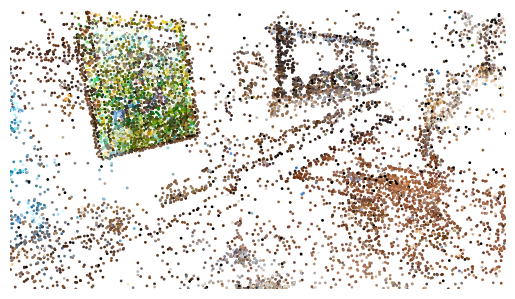

In [43]:
plt.scatter(bounded_points[:, 0], bounded_points[:, 1], c=bounded_colors, s=1)
plt.xlim(0, colmap_data.width)
plt.ylim(colmap_data.height, 0)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.savefig('docs/images/projected_frame_00001.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [74]:
# Visualize covariance with scaled down
viz_scaling = 0.1
big_mesh = create_ellipsoids_as_one_mesh(model.points, sigmas*viz_scaling, model.colors, sphere_resolution=10)
o3d.visualization.draw_geometries([big_mesh])

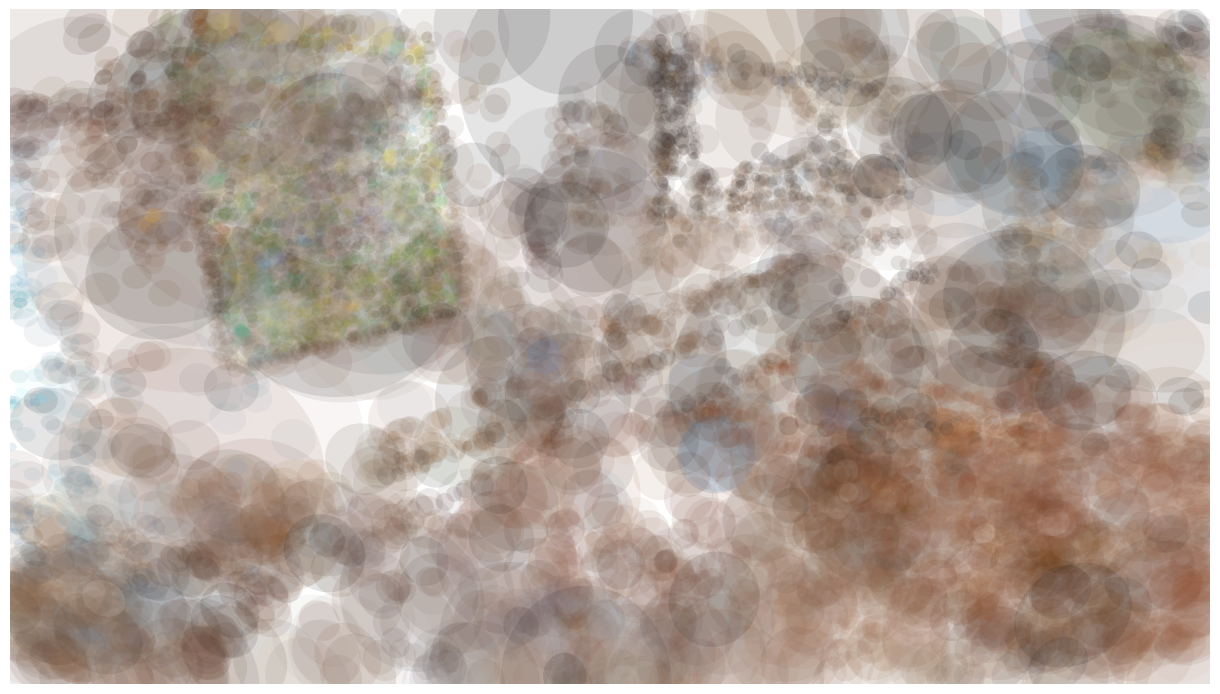

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))

# for anisotropic covariance, modify this
eigenvals, eigenvecs = np.linalg.eigh(bound_sigmas_2d*viz_scaling)

angles = np.degrees(np.arctan2(eigenvecs[:, 1, 0], eigenvecs[:, 0, 0]))
widths = 2 * np.sqrt(eigenvals[:, 0])
heights = 2 * np.sqrt(eigenvals[:, 1])

ec = EllipseCollection(
    widths, heights, angles,
    units='x',
    offsets=bounded_points,
    transOffset=ax.transData,
    facecolors=bounded_colors,
    alpha=0.1
)

ax.add_collection(ec)

# ax.scatter(bounded_points[:, 0], bounded_points[:, 1], 
#           c=bounded_colors, s=1, alpha=0.5)

ax.set_aspect('equal')
ax.set_xlim(0, colmap_data.width)
ax.set_ylim(colmap_data.height, 0)
ax.axis('off')
plt.gca().set_position([0, 0, 1, 1])
plt.savefig('docs/images/projected_gaussian_00001.png', 
            bbox_inches='tight',
            pad_inches=0)
plt.show()

In [7]:
# To project covariance to image, apply differentiable tile rasterizer

"""
1. split screen into 16x16 pixel tiles.
2. cull gaussians
 - 99% confidence interval within bounds
 - extreme positions (near and far plane (?)) to avoid unstable 2D covariance
3. instantiate gaussian with idx of tils they overlap (?)
4. assign each gaussian with key (view space depth, tile ID)
5. Radix sort with GPU (no per-pixel ordering)

6. Accumulate color and alpha from front to back until we reach target saturation (T_alpha)

"""

'\n1. split screen into 16x16 pixel tiles.\n2. cull gaussians\n - 99% confidence interval within bounds\n - extreme positions (near and far plane (?)) to avoid unstable 2D covariance\n3. instantiate gaussian with idx of tils they overlap (?)\n4. assign each gaussian with key (view space depth, tile ID)\n5. Radix sort with GPU (no per-pixel ordering)\n\n6. Accumulate color and alpha from front to back until we reach target saturation (T_alpha)\n\n'

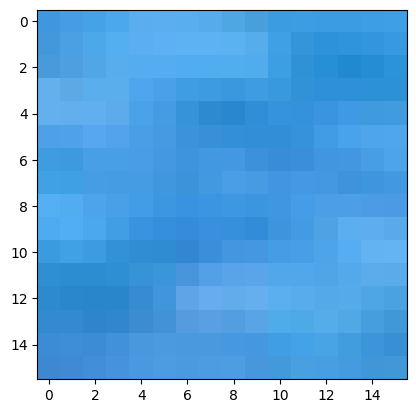

In [8]:
img_name = colmap_data.frame_names[0]
img = plt.imread(f"data/images/{img_name}")
tile = img[:16, :16]
plt.imshow(tile)
plt.show()

In [10]:
# Test matrices by back-projecting tile pixel space to 3D space

tile_x1 = 0
tile_x2 = 960
tile_y1 = 0
tile_y2 = 540   
tile_pixels = np.array([[tile_x1, tile_y1], 
                        [tile_x2, tile_y1], 
                        [tile_x1, tile_y2], 
                        [tile_x2, tile_y2]])
# tile_pixels = bounded_points[0][np.newaxis]

idx = 1

# depth = None
depth = bounded_depths[idx]

tile_cam = to_homogeneous(tile_pixels) @ np.linalg.inv(K).T * depth
tile_world = (to_homogeneous(tile_cam) @ np.linalg.inv(E).T)
# normalize if we want to get a ray, without original depth
if depth is None:
    tile_world = tile_world[:, :3] / tile_world[:, 3:]
else:
    tile_world = tile_world[:, :3]

current_point = points[bound_indices][idx]

assert tile_world[:, 0].min() <= current_point[0] <= tile_world[:, 0].max()
assert tile_world[:, 1].min() <= current_point[1] <= tile_world[:, 1].max()
assert tile_world[:, 2].min() <= current_point[2] <= tile_world[:, 2].max()

print(tile_world)
print('Current point is in the view frustum')
print(current_point)

[[-9.51185499 -5.72680027 10.46599257]
 [ 9.16030591 -5.21008555 11.03414842]
 [-9.80948267  4.83949568 10.63776098]
 [ 8.86267824  5.3562104  11.20591683]]
Current point is in the view frustum
[-5.64985792  2.87904996 10.72883788]


In [11]:
# Gaussians with 99% confidence interval intersecting the view frustum
# so ensure 2 * scale *2.58 or 2* 2.58 * sqrt(diagonal(sigma)) is in view

tile_world

array([[-9.51185499, -5.72680027, 10.46599257],
       [ 9.16030591, -5.21008555, 11.03414842],
       [-9.80948267,  4.83949568, 10.63776098],
       [ 8.86267824,  5.3562104 , 11.20591683]])

In [12]:
sigmas[bound_indices]

array([[[0.25105764, 0.        , 0.        ],
        [0.        , 0.25105764, 0.        ],
        [0.        , 0.        , 0.25105764]],

       [[0.7958395 , 0.        , 0.        ],
        [0.        , 0.7958395 , 0.        ],
        [0.        , 0.        , 0.7958395 ]],

       [[0.37406752, 0.        , 0.        ],
        [0.        , 0.37406752, 0.        ],
        [0.        , 0.        , 0.37406752]],

       ...,

       [[0.16685917, 0.        , 0.        ],
        [0.        , 0.16685917, 0.        ],
        [0.        , 0.        , 0.16685917]],

       [[0.09313987, 0.        , 0.        ],
        [0.        , 0.09313987, 0.        ],
        [0.        , 0.        , 0.09313987]],

       [[0.20711867, 0.        , 0.        ],
        [0.        , 0.20711867, 0.        ],
        [0.        , 0.        , 0.20711867]]])